# Support Vector Machines for Fall detection

In this Python notebook I create different SVM models for detecting falls using 3 sensors (accelerometer, gyroscope and magnetometer). This work uses FallAllD dataset, which was created by Saleh *et al*., (2021). The model will use all three axis of all three sensors. The dataset had to be modied for having a column for fall, in which 1 represents a fall, otherwise is an ADL. For comparison, another dataset has been created, which uses a second output column. This column, ADL, will have the opposite value of Fall. 

A third and fourth dataset was created in which basic statistical features are being used. Those features are: Mean, Standard Deviation and Range. These features were extracted for each of the axis of each sensor. A fifth and sixth dataset was created using the same features, altough just considering accelerometer data, just like Saleh *et al*., (2021) did in their work.

### Importing libraries

This libraries will help throughout the code

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import requests
import time
import pickle
from random import seed, randint

### Notification System

This function will be used to send a Telegram message when training is done.

In [3]:
f = open("Notification system/Telegram Token.txt")
token = f.read()

def broadcast_message(chat, message):
    for chat_to_send in chat:
        URL = 'https://api.telegram.org/bot{}/sendMessage?chat_id={}&text={}'.format(token, chat_to_send, message)
        resp = requests.get(URL)
        print(resp.text)

#### Test notification system

Please follow  the steps in the paper and add your chat id here to test the notification system and receive a message  in your Telegram app.

In [ ]:
chat_id = input('What is your Telegram ID given by the bot?\n')

id_to_send = []
id_to_send.append(chat_id)

message = "This is a test! Notification system is working properly."

broadcast_message(id_to_send, message)

## Creating first SVM model

Choosing the best SVM kernel. The kernel can be Linear, Polynomial, Radial Basis Function and Sigmoid. For this paper we will be working with linear kernel.


#### Reading frist dataframe

This is the dataframe containing one output column with raw data from all 3 sensors.

In [4]:
df = pd.read_pickle('Dataframes/Dataframe3.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SubjectID   1798 non-null   int8   
 1   Device      1798 non-null   object 
 2   ActivityID  1798 non-null   int16  
 3   TrialNo     1798 non-null   int8   
 4   Acc         1798 non-null   object 
 5   Gyr         1798 non-null   object 
 6   Mag         1798 non-null   object 
 7   Mean Acc X  1798 non-null   float64
 8   Mean Acc Y  1798 non-null   float64
 9   Mean Acc Z  1798 non-null   float64
 10  Std Acc X   1798 non-null   float64
 11  Std Acc Y   1798 non-null   float64
 12  Std Acc Z   1798 non-null   float64
 13  Rng Acc X   1798 non-null   float64
 14  Rng Acc Y   1798 non-null   float64
 15  Rng Acc Z   1798 non-null   float64
 16  Mean Gyr X  1798 non-null   float64
 17  Mean Gyr Y  1798 non-null   float64
 18  Mean Gyr Z  1798 non-null   float64
 19  Std Gyr X   1798 non-null  

In [5]:
X = df.iloc[:, 7:34]       # Defining X as Acce, Gyro and Mag data
X.info()                   # Printing X's info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mean Acc X  1798 non-null   float64
 1   Mean Acc Y  1798 non-null   float64
 2   Mean Acc Z  1798 non-null   float64
 3   Std Acc X   1798 non-null   float64
 4   Std Acc Y   1798 non-null   float64
 5   Std Acc Z   1798 non-null   float64
 6   Rng Acc X   1798 non-null   float64
 7   Rng Acc Y   1798 non-null   float64
 8   Rng Acc Z   1798 non-null   float64
 9   Mean Gyr X  1798 non-null   float64
 10  Mean Gyr Y  1798 non-null   float64
 11  Mean Gyr Z  1798 non-null   float64
 12  Std Gyr X   1798 non-null   float64
 13  Std Gyr Y   1798 non-null   float64
 14  Std Gyr Z   1798 non-null   float64
 15  Rng Gyr X   1798 non-null   float64
 16  Rng Gyr Y   1798 non-null   float64
 17  Rng Gyr Z   1798 non-null   float64
 18  Mean Mag X  1798 non-null   float64
 19  Mean Mag Y  1798 non-null  

In [6]:
y = df['Fall']          # Defining y as Fall column, this means setting y to our output.
y.tail()                # y is a Series object

1793    1
1794    1
1795    1
1796    1
1797    1
Name: Fall, dtype: int64

#### Using GridSearchCV

By using the function GridSearchCV we can train an validate different SVM models with different **C** values for obtaining the best model with the best accuracy.


In [7]:
params = {'C': (0.001, 0.01, 0.1, 1, 10, 50, 100, 1000),
         'kernel': ('linear', 'poly', 'rbf')}

clf_grid = GridSearchCV(SVC(), params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

clf_grid.fit(X,y)
print(clf_grid.best_params_)
df_grid_results = pd.DataFrame(clf_grid.cv_results_)
print(df_grid_results)
broadcast_message(['1766671538'], 'GridSearchCV is done!')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 1, 'kernel': 'linear'}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        1.052597      0.233656         0.044468        0.043068   0.001   
1        0.299796      0.033051         0.065625        0.025655   0.001   
2        0.325126      0.031548         0.187099        0.026705   0.001   
3        4.489988      1.140911         0.024733        0.018155    0.01   
4        0.248530      0.024639         0.052859        0.016364    0.01   
5        0.246738      0.025760         0.163562        0.016376    0.01   
6       45.275587     11.385796         0.030120        0.026155     0.1   
7        0.243147      0.032743         0.048271        0.014679     0.1   
8        0.189590      0.016888         0.118682        0.017343     0.1   
9      240.399732     74.145864         0.024335        0.021919       1   
10       0.388360      0.086837         0.032514        0.018309       1 

In [16]:
df_grid_results[['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'C': 0.001, 'kernel': 'linear'}",0.907136,10
1,"{'C': 0.001, 'kernel': 'poly'}",0.756948,22
2,"{'C': 0.001, 'kernel': 'rbf'}",0.740823,24
3,"{'C': 0.01, 'kernel': 'linear'}",0.921594,7
4,"{'C': 0.01, 'kernel': 'poly'}",0.763618,21
5,"{'C': 0.01, 'kernel': 'rbf'}",0.753610,23
6,"{'C': 0.1, 'kernel': 'linear'}",0.928821,5
7,"{'C': 0.1, 'kernel': 'poly'}",0.785310,20
8,"{'C': 0.1, 'kernel': 'rbf'}",0.832043,17
9,"{'C': 1, 'kernel': 'linear'}",0.936613,1


#### Creating variable with SVM model

In [3]:
clf = SVC(kernel='linear')          # Parameter tuning is needed to get better results

#### Using tain test split

This function will help us to create a separate pandas DataFrame for testing the end result. So we are separating 10% of the data into a test set. With this we will be using the other 90% for training and validating our models.

In [7]:
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=10, stratify=y)
X_rem.shape, X_test.shape

((1618, 27), (180, 27))

#### Using StratifiedKFold

Since we are using a K-Fold Cross Validation approach, we have to use KFold to create our folds for training and testing. In this case we will be using k = 10, where 9 sets will be used for training and 1 for validating. So this way every set gets a chance to be validated. 

By using StratifiedKFold we make sure that the output class is evenly distribuited through each fold. So this means that they are smaller chances of having only Falls in on set.

In [10]:
scores_linear_1 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=42)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X_rem, y_rem):                      # Splitting dataset into 10 fold 
    X_train, X_val = X_rem.iloc[train_index], X_rem.iloc[val_index]
    y_train, y_val = y_rem.iloc[train_index] , y_rem.iloc[val_index]

    clf.fit(X_train, y_train)
    scores_linear_1.append(clf.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', (sum(scores_linear_1) / len(scores_linear_1)*100))         # 0.9486 accuracy   Randomstate=17 0.9498 accuracy

{"ok":true,"result":{"message_id":90,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634148481,"text":"Training is done!"}}
Linear accuracy score:  94.68522352580322


In [150]:
y_predicted_1 = clf.predict(X_test)      
print('Accuracy: ', (accuracy_score(y_test, y_predicted_1))*100)

Accuracy:  93.86503067484662


#### Saving Model to disk

In [12]:
filename = 'SVM_linear_1.sav'
pickle.dump(clf, open(filename, 'wb'))

#### Using notification system

With the for loop, we can iterate between each predicted value and send an alert when predicted a fall with the message: "**Fall Detected**", when a fall was not detected, "**Not a Fall**" will be sent.

In [53]:
for i in range(len(y_predicted_1)):
    
    if y_predicted_1[i] == 1:
        broadcast_message(['1766671538'], 'Fall detected!')

    else:
        broadcast_message(['1766671538'], 'Not a Fall!')
    
    time.sleep(30)

{"ok":true,"result":{"message_id":78,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133587,"text":"Not a Fall!"}}
{"ok":true,"result":{"message_id":79,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133618,"text":"Fall detected!"}}
{"ok":true,"result":{"message_id":80,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133649,"text":"Not a Fall!"}}
{"ok":true,"result":{"message_id":81,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"ch

#### Plotting Confusion Matrix

Plotting confusion matrix for better visualization of true positves and false negatives

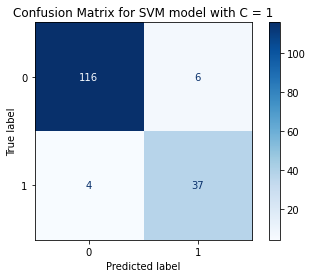

In [151]:
con_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted_1)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1')
plt.show()

In [16]:
params = {'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000)}

#### Using Grid Search CV
Using grid search CV once again to find the best C parameter for a linear SVM model.

In [17]:
clf_grid = GridSearchCV(SVC(), params, cv=10, n_jobs=-1, verbose=1, scoring='accuracy')
clf_grid.fit(X,y)
print(clf_grid.best_params_)
df_grid_results = pd.DataFrame(clf_grid.cv_results_)
print(df_grid_results)
broadcast_message(['1766671538'], 'GridSearchCV is done!')

Fitting 10 folds for each of 13 candidates, totalling 130 fits
{'C': 1000}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.099133      0.006573         0.028225        0.001997   0.001   
1        0.093451      0.005105         0.027425        0.004241   0.005   
2        0.135038      0.024712         0.033711        0.005814    0.01   
3        0.099633      0.008351         0.026330        0.003709    0.05   
4        0.123569      0.020548         0.036204        0.010751     0.1   
5        0.234971      0.080584         0.067818        0.042888     0.5   
6        0.124178      0.017796         0.029559        0.007611       1   
7        0.109806      0.012784         0.020745        0.002815       5   
8        0.105319      0.011726         0.027576        0.007906      10   
9        0.158723      0.031187         0.024145        0.008660      50   
10       0.156629      0.033567         0.020507        0.003821     100   
11       0.28

In [19]:
df_grid_results[['param_C', 'mean_test_score', 'rank_test_score']]

,param_C,mean_test_score,rank_test_score
0,0.001,0.741077,12
1,0.005,0.741077,12
2,0.01,0.741082,11
3,0.05,0.822796,10
4,0.1,0.832390,9
5,0.5,0.862617,8
6,1,0.885985,7
7,5,0.903165,5
8,10,0.903155,6
9,50,0.909343,4


### Creating another SVM model
Since Grid Search found that the best model should have C = 1000, we will train a model with it and save it on disk.

In [17]:
clf_lin_1000 = SVC(kernel='linear', C=1000)
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=17, stratify=y)
X_rem.shape, X_test.shape
scores_lin_1000 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=17)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X_rem, y_rem):                      # Splitting dataset into 10 fold 
    X_train, X_val = X_rem.iloc[train_index], X_rem.iloc[val_index]
    y_train, y_val = y_rem.iloc[train_index] , y_rem.iloc[val_index]

    clf_lin_1000.fit(X_train, y_train)
    scores_lin_1000.append(clf_lin_1000.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_lin_1000) / len(scores_lin_1000)) 

In [146]:
y_predicted_1000 = clf_lin_1000.predict(X_test)       # 0.95      randomstate=17 0.9567 accuracy
print('Accuracy: ', accuracy_score(y_test, y_predicted_1000))

Accuracy:  0.9447852760736196


#### Saving model to disk

Saving the model to disk so it can be loaded afterwards.

In [28]:
filename = 'SVM_linear_1000.sav'
pickle.dump(clf_lin_1000, open(filename, 'wb'))

#### Plotting Confusion Matrix

By plotting the confusion matrix of the model, we can visualize easier the false positives and false negatives.

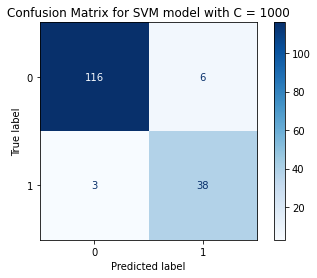

In [145]:
con_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted_1000)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1000')
plt.show()

## Creating second SVM model

In this section we will be creating a second SVM model by using only acceleration characteristics, instead of all three as the model created before. The characteristics are unchanged, we will use mean, standard deviation and range of acceleration for its three axes. We will have it predict 1 output variable. This output are, Fall or ADL.  

#### Reading dataframe 

In [113]:
df2 = pd.read_pickle('Dataframes/Dataframe5.pkl')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SubjectID   1798 non-null   int8   
 1   Device      1798 non-null   object 
 2   ActivityID  1798 non-null   int16  
 3   TrialNo     1798 non-null   int8   
 4   Acc         1798 non-null   object 
 5   Gyr         1798 non-null   object 
 6   Mag         1798 non-null   object 
 7   Mean Acc X  1798 non-null   float64
 8   Mean Acc Y  1798 non-null   float64
 9   Mean Acc Z  1798 non-null   float64
 10  Std Acc X   1798 non-null   float64
 11  Std Acc Y   1798 non-null   float64
 12  Std Acc Z   1798 non-null   float64
 13  Rng Acc X   1798 non-null   float64
 14  Rng Acc Y   1798 non-null   float64
 15  Rng Acc Z   1798 non-null   float64
 16  Fall        1798 non-null   int64  
dtypes: float64(9), int16(1), int64(1), int8(2), object(4)
memory usage: 203.8+ KB


#### Separating X and y variables

In [115]:
X2 = df2.iloc[:, 7:16]
y2 = df2['Fall']
X2.head()

,Mean Acc X,Mean Acc Y,Mean Acc Z,Std Acc X,Std Acc Y,Std Acc Z,Rng Acc X,Rng Acc Y,Rng Acc Z
0,0.921582,-0.201560,0.171808,0.067198,0.165769,0.187205,0.654164,0.938668,0.608780
1,0.909689,-0.274133,0.174786,0.030403,0.132192,0.165149,0.417484,0.664656,0.509960
2,0.924141,-0.008939,0.212514,0.099426,0.159648,0.233055,0.813496,0.801784,0.826428
3,0.909702,-0.031952,0.234640,0.067926,0.161555,0.249287,0.504592,0.759572,0.670024
4,0.903871,0.170773,0.213385,0.133012,0.162354,0.238117,1.128500,0.939400,0.922808


#### Creating SVM model and separating variables into train/test and validation sets

In [116]:
clf2 = SVC(kernel='linear')

X_rem_2, X_test_2, y_rem_2, y_test_2 = train_test_split(X2, y2, test_size=0.1, train_size=0.9, random_state=29, stratify=y2)
X_rem_2.shape, X_test_2.shape

((1618, 9), (180, 9))

#### Using StatifiedKFold for training and testing new SVM model

In [117]:
scores_2_lin_1 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=92)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X_rem_2, y_rem_2):                      # Splitting dataset into 10 fold 
    X_train, X_val = X_rem_2.iloc[train_index], X_rem_2.iloc[val_index]
    y_train, y_val = y_rem_2.iloc[train_index] , y_rem_2.iloc[val_index]

    clf2.fit(X_train, y_train)
    scores_2_lin_1.append(clf2.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_2_lin_1) / len(scores_2_lin_1))

{"ok":true,"result":{"message_id":104,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634420819,"text":"Training is done!"}}
Linear accuracy score:  0.9190322828003987


In [118]:
y2_predicted = clf2.predict(X_test_2)
print('Accuracy: ', (accuracy_score(y_test_2, y2_predicted))*100)

Accuracy:  88.88888888888889


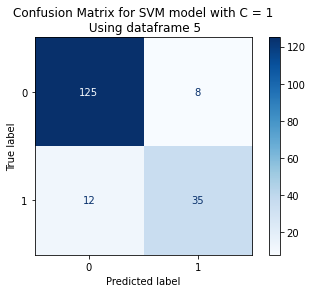

In [119]:
con_mat = confusion_matrix(y_true=y_test_2, y_pred=y2_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1\n Using dataframe 5')
plt.show()

#### Saving model to disk

In [120]:
filename = 'SVM_linear_1_dataframe5.sav'
pickle.dump(clf2, open(filename, 'wb'))

#### Using grid search

In [121]:
params = {'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000)}
clf_grid2 = GridSearchCV(SVC(), params, cv=10, n_jobs=-1, verbose=1, scoring='accuracy')
clf_grid2.fit(X2,y2)
print(clf_grid2.best_params_)
df_grid_results = pd.DataFrame(clf_grid2.cv_results_)
broadcast_message(['1766671538'], 'GridSearchCV is done!')

Fitting 10 folds for each of 13 candidates, totalling 130 fits
{'C': 1000}
{"ok":true,"result":{"message_id":105,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634420896,"text":"GridSearchCV is done!"}}


In [122]:
df_grid_results[['param_C', 'mean_test_score', 'rank_test_score']]

,param_C,mean_test_score,rank_test_score
0,0.001,0.740826,13
1,0.005,0.809224,12
2,0.01,0.884863,11
3,0.05,0.898777,10
4,0.1,0.904336,9
5,0.5,0.917700,8
6,1,0.940512,7
7,5,0.951639,6
8,10,0.954413,5
9,50,0.959401,4


#### Creating new model using the parameter given by GridSearchCV

In [123]:
clf2_1000 = SVC(kernel='linear', C=1000)
X_rem_2, X_test_2, y_rem_2, y_test_2 = train_test_split(X2, y2, test_size=0.1, train_size=0.9, random_state=29, stratify=y2)
X_rem_2.shape, X_test_2.shape
scores2_1000 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=92)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X_rem_2, y_rem_2):                      # Splitting dataset into 10 fold 
    X_train, X_val = X_rem_2.iloc[train_index], X_rem_2.iloc[val_index]
    y_train, y_val = y_rem_2.iloc[train_index] , y_rem_2.iloc[val_index]

    clf2_1000.fit(X_train, y_train)
    scores2_1000.append(clf2_1000.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores2_1000) / len(scores2_1000)) 

{"ok":true,"result":{"message_id":106,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634420974,"text":"Training is done!"}}
Linear accuracy score:  0.9171804309485468


In [124]:
y2_predicted_1000 = clf2_1000.predict(X_test_2)
print('Accuracy: ', (accuracy_score(y_test_2, y2_predicted_1000))*100)

Accuracy:  88.33333333333333


#### Plotting Confusion Matrix

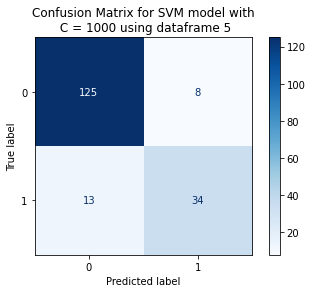

In [125]:
con_mat = confusion_matrix(y_true=y_test_2, y_pred=y2_predicted_1000)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n C = 1000 using dataframe 5')
plt.show()

#### Saving model to disk

In [126]:
filename= 'SVM_linear_1000_Dataframe5.sav'
pickle.dump(clf2_1000, open(filename, 'wb'))

## Using Leave-One-Subject-Out method

In this section of the notebook, we will create a svm model but leaving 1 subject out for final testing. This is done to show that the model created is not subject-dependent.

Subject out was number 13.

#### Reading dataframe

In [35]:
df3 = pd.read_pickle('Dataframes/Dataframe3.pkl')
subject_out = df3[df3['SubjectID'] == 13]
subject_out.reset_index(drop=True, inplace=True)
subject_out.head()

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Mean Acc X,Mean Acc Y,Mean Acc Z,...,Mean Mag X,Mean Mag Y,Mean Mag Z,Std Mag X,Std Mag Y,Std Mag Z,Rng Mag X,Rng Mag Y,Rng Mag Z,Fall
0,13,Waist,13,1,"[[1.187792, 0.11834, 0.061], [1.098976, 0.1385...","[[3.8500000000000005, -13.23, 7.00000000000000...","[[0.5397, 0.08442, 0.36245999999999995], [0.53...",0.909446,-0.207685,0.195117,...,0.525232,0.245418,0.222293,0.025104,0.067875,0.092003,0.19334,0.36848,0.58870,0
1,13,Waist,13,2,"[[0.99918, 0.043676, 0.04026], [0.999668, 0.04...","[[0.42000000000000004, 2.66, 0.700000000000000...","[[0.5796, 0.06888, 0.40165999999999996], [0.58...",0.910689,-0.211511,0.164247,...,0.546069,0.166859,0.297884,0.028882,0.095824,0.088503,0.08372,0.29834,0.29708,0
2,13,Waist,13,3,"[[1.415444, -0.00244, 0.083448], [1.4679039999...","[[33.53, 45.220000000000006, -40.95], [30.5900...","[[0.5292, 0.10401999999999999, 0.4069799999999...",0.959760,-0.138148,0.149002,...,0.498201,0.334305,0.298323,0.044865,0.095063,0.101606,0.17234,0.37240,0.51352,0
3,13,Waist,13,4,"[[0.9964959999999999, 0.054168, 0.104432], [0....","[[2.8000000000000003, 0.9100000000000001, 0.56...","[[0.5690999999999999, 0.32942, 0.3456599999999...",0.937242,-0.153876,0.163681,...,0.502416,0.376588,0.358075,0.071241,0.055801,0.022026,0.17234,0.18508,0.10682,0
4,13,Waist,13,5,"[[0.930128, 0.061732, 0.014152], [0.94428, 0.0...","[[32.620000000000005, 24.220000000000002, 47.1...","[[0.48411999999999994, 0.01078, 0.32214], [0.4...",0.956477,0.050190,0.144145,...,0.531190,0.193558,0.258704,0.023015,0.064773,0.080942,0.13734,0.32648,0.52332,0


#### Dropping subject and separating variables

In [36]:
df3.drop(df3[df3.SubjectID == 13].index, inplace=True)
df3.reset_index(drop=True, inplace=True)
X3 = df3.iloc[: ,7:34]
y3 = df3['Fall']
X3

,Mean Acc X,Mean Acc Y,Mean Acc Z,Std Acc X,Std Acc Y,Std Acc Z,Rng Acc X,Rng Acc Y,Rng Acc Z,Mean Gyr X,...,Rng Gyr Z,Mean Mag X,Mean Mag Y,Mean Mag Z,Std Mag X,Std Mag Y,Std Mag Z,Rng Mag X,Rng Mag Y,Rng Mag Z
0,0.921582,-0.201560,0.171808,0.067198,0.165769,0.187205,0.654164,0.938668,0.608780,-4.077706,...,82.11,0.788509,0.306360,0.248950,0.030355,0.062698,0.103449,0.15960,0.27286,0.36050
1,0.909689,-0.274133,0.174786,0.030403,0.132192,0.165149,0.417484,0.664656,0.509960,-0.843176,...,97.65,0.756194,0.379925,0.255541,0.032967,0.034068,0.074790,0.14658,0.16366,0.22442
2,0.924141,-0.008939,0.212514,0.099426,0.159648,0.233055,0.813496,0.801784,0.826428,-1.126853,...,97.30,0.799671,0.254084,0.270394,0.016859,0.051702,0.115595,0.09912,0.26320,0.41986
3,0.909702,-0.031952,0.234640,0.067926,0.161555,0.249287,0.504592,0.759572,0.670024,-1.021162,...,129.43,0.777614,0.318550,0.280543,0.015691,0.037413,0.119515,0.09464,0.17402,0.32018
4,0.903871,0.170773,0.213385,0.133012,0.162354,0.238117,1.128500,0.939400,0.922808,-0.143515,...,93.80,0.808201,0.202960,0.264524,0.021063,0.051833,0.114198,0.09968,0.28686,0.39298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,0.421164,0.486860,-0.259032,0.482082,0.413782,0.403274,3.109536,6.272264,7.321708,-13.848500,...,429.10,0.255893,0.063975,0.584274,0.155849,0.054347,0.116918,0.51660,0.49532,0.92008
1617,0.477437,-0.463409,-0.259671,0.525878,0.407719,0.456425,12.972016,11.122984,14.119792,2.177412,...,477.61,0.413253,0.238942,0.357015,0.084351,0.155681,0.124277,0.34916,0.38920,0.64218
1618,0.516297,0.216274,-0.216580,0.416558,0.605298,0.381468,5.058364,3.708556,6.397192,1.489456,...,475.37,0.337363,0.058966,0.370667,0.181615,0.105069,0.136420,0.43820,0.41636,0.78834
1619,0.838070,0.347216,0.030255,0.210071,0.364009,0.147526,4.985652,3.778584,5.548072,-2.024441,...,408.31,0.470200,0.140514,0.245743,0.021936,0.126791,0.167907,0.13300,0.35028,0.64596


#### Creating and training/validating model without subject # 13

In [37]:
clf3 = SVC(kernel='linear')
scores_3 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=758)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X3, y3):                      # Splitting dataset into 10 fold 
    X_train, X_val = X3.iloc[train_index], X3.iloc[val_index]
    y_train, y_val = y3.iloc[train_index] , y3.iloc[val_index]

    clf3.fit(X_train, y_train)
    scores_3.append(clf3.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_3) / len(scores_3))

{"ok":true,"result":{"message_id":99,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634321408,"text":"Training is done!"}}
Linear accuracy score:  0.9487843671892751


In [38]:
subject_out_X = subject_out.iloc[:, 7:34]
subject_out_y = subject_out['Fall']
subject_out_X.shape, subject_out_y.shape

((177, 27), (177,))

#### Testing model with subject 13

To test the accuracy of the model create above, we will test the model with the subject that was left out.

In [39]:
subject_out_predicted = clf3.predict(subject_out_X)
print('Accuracy: ', (accuracy_score(subject_out_y, subject_out_predicted))*100)

Accuracy:  92.65536723163842


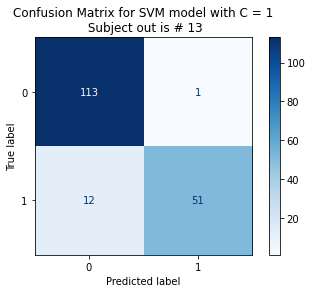

In [41]:
con_mat = confusion_matrix(y_true=subject_out_y, y_pred=subject_out_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1\n Subject out is # 13')
plt.show()

#### Saving model to disk

In [10]:
filename= 'SVM_linear_subject_out.sav'
pickle.dump(clf3, open(filename, 'wb'))

## Testing model of subject out

In [9]:
seed(29872)
value = []
for x in range(3):              # Generating 3 random integers to test the model
    value.append(randint(1,15))
    print(value)

[4]
[4, 8]
[4, 8, 7]


#### Separating subject

Getting rows with all columns that represent data rom subject 4

In [29]:
df3 = pd.read_pickle('Dataframes/Dataframe3.pkl')
subject_out = df3[df3['SubjectID'] == 4]
subject_out.reset_index(drop=True, inplace=True)

#### Loading model from disk

The model that is loaded is the one created by leaving out subject 13 from training. We will be testing the model using subjects that were used in training.

In [17]:
clf_subject_out = pickle.load(open('SVM_linear_subject_out.sav', 'rb'))

#### Dividing independent and dependent variables

In [28]:
X_subject_out = subject_out.iloc[:,7:34]
y_subject_out = subject_out['Fall']

#### Testing model with subject 4

Accuracy with another subject: 0.9382716049382716


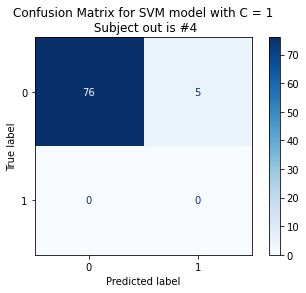

In [19]:
y_predicted_subject_out = clf_subject_out.predict(X_subject_out)
print('Accuracy with another subject:', accuracy_score(y_subject_out, y_predicted_subject_out))

con_mat = confusion_matrix(y_true=y_subject_out, y_pred=y_predicted_subject_out)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1\n Subject out is #4')
plt.show()

#### Testing model with subject 8

Accuracy with another subject: 0.9174311926605505


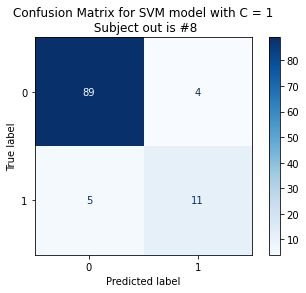

In [21]:
df3 = pd.read_pickle('Dataframes/Dataframe3.pkl')
subject_out = df3[df3['SubjectID'] == 8]
subject_out.reset_index(drop=True, inplace=True)

X_subject_out = subject_out.iloc[:,7:34]
y_subject_out = subject_out['Fall']

y_predicted_subject_out = clf_subject_out.predict(X_subject_out)
print('Accuracy with another subject:', accuracy_score(y_subject_out, y_predicted_subject_out))

con_mat = confusion_matrix(y_true=y_subject_out, y_pred=y_predicted_subject_out)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1\n Subject out is #8')
plt.show()

#### Testing model with subject 7

Accuracy with another subject: 0.9456521739130435


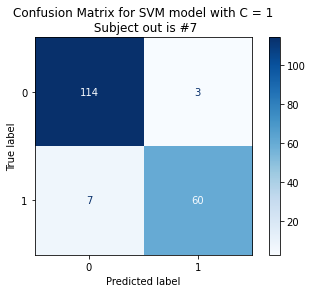

In [35]:
df3 = pd.read_pickle('Dataframes/Dataframe3.pkl')
subject_out = df3[df3['SubjectID'] == 7]
subject_out.reset_index(drop=True, inplace=True)

X_subject_out = subject_out.iloc[:,7:34]

y_subject_out = subject_out['Fall']

y_predicted_subject_out = clf_subject_out.predict(X_subject_out)
print('Accuracy with another subject:', accuracy_score(y_subject_out, y_predicted_subject_out))

con_mat = confusion_matrix(y_true=y_subject_out, y_pred=y_predicted_subject_out)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1\n Subject out is #7')
plt.show()

## Creating new model with 3 subjects out to test accuracy

In this model, training is done withou 3 subjects. Those subjects IDs are: 4, 7 and 8. Afterwards, accuracy score will be based on the predictions made by the model on those three subjects.

In [10]:
print(value)

[4, 8, 7]


#### Removing random subjects for testing purposes

In [18]:

df4 = pd.read_pickle('Dataframes/Dataframe3.pkl')
subject_out = df4[df4['SubjectID'] == 4]                        # When tested alone it had an accuracy of 92.59
subject_out = subject_out.append(df4[df4['SubjectID'] == 8])    # When tested alone it had an accuracy of 89.90
subject_out = subject_out.append(df4[df4['SubjectID'] == 7])    # When tested alone it had an accuracy of 86.95
for x in range(3):
    df4.drop(df4[df4.SubjectID == value[x]].index, inplace=True)
    

subject_out.reset_index(drop=True, inplace=True)
df4.reset_index(drop=True, inplace=True)
X3 = df4.iloc[: ,7:34]
y3 = df4['Fall']
X_subject_out = subject_out.iloc[:, 7:34]
y_subject_out = subject_out['Fall']
subject_out

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Mean Acc X,Mean Acc Y,Mean Acc Z,...,Mean Mag X,Mean Mag Y,Mean Mag Z,Std Mag X,Std Mag Y,Std Mag Z,Rng Mag X,Rng Mag Y,Rng Mag Z,Fall
0,4,Waist,13,5,"[[0.9323239999999999, 0.250588, -0.240096], [0...","[[12.46, 6.720000000000001, 3.3600000000000003...","[[0.36022, 0.34328, 0.9465399999999999], [0.36...",0.710917,0.412293,0.258561,...,0.201420,0.227774,0.950763,0.140818,0.102136,0.213355,0.44884,0.39452,0.80038,0
1,4,Waist,13,6,"[[0.946232, 0.285968, 0.196664], [0.934276, 0....","[[38.85, 8.47, 13.580000000000002], [40.320000...","[[0.26768, 0.16155999999999998, 0.903419999999...",0.609119,0.450429,0.448918,...,0.130592,0.172589,0.777118,0.132449,0.010619,0.112765,0.31206,0.07168,0.27916,0
2,4,Waist,13,8,"[[0.853268, 0.42578, 0.156892], [0.849608, 0.4...","[[-11.760000000000002, -0.35000000000000003, -...","[[0.28812, 0.19068, 1.24796], [0.2890999999999...",0.766136,0.510574,0.282644,...,0.272868,0.169999,1.163929,0.017516,0.027627,0.080432,0.05684,0.09968,0.21714,0
3,4,Waist,13,9,"[[1.318088, -0.075396, 0.071004], [1.382992, -...","[[74.41000000000001, 75.81, -7.490000000000001...","[[0.3031, 0.45653999999999995, 0.7859599999999...",0.885489,0.112642,0.319031,...,0.258991,0.289281,0.867124,0.060359,0.110449,0.186161,0.17416,0.34692,0.56336,0
4,4,Waist,13,11,"[[0.726876, 0.114192, 0.551196], [0.793976, 0....","[[-6.86, 38.50000000000001, -10.01000000000000...","[[0.34174, 0.36763999999999997, 0.881579999999...",0.786925,0.391165,0.340511,...,0.302973,0.229208,1.034045,0.036124,0.074548,0.140267,0.29106,0.27902,0.88116,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,7,Waist,133,1,"[[0.9699, 0.074908, -0.131272], [0.970388, 0.0...","[[-1.54, 1.54, -0.6300000000000001], [-1.96000...","[[0.6202, -0.06817999999999999, 1.097319999999...",0.289409,0.473134,0.061094,...,0.489188,-0.227064,0.992825,0.140160,0.165047,0.099177,0.56896,0.39368,0.37450,1
370,7,Waist,134,1,"[[0.9015799999999999, 0.360876, -0.127124], [0...","[[-0.77, 2.1700000000000004, 1.33], [-2.030000...","[[0.5909399999999999, -0.31961999999999996, 1....",0.265955,0.363287,0.384298,...,0.466250,-0.299380,1.002069,0.133864,0.028454,0.343562,0.45598,0.20510,0.76314,1
371,7,Waist,134,2,"[[0.86254, 0.459696, -0.086376], [0.861564, 0....","[[-1.2600000000000002, 0.77, 0.56], [-1.54, 0....","[[0.5726, -0.36904, 1.3642999999999998], [0.57...",0.410056,0.209789,-0.547802,...,0.365947,-0.215355,1.346780,0.210943,0.157276,0.023506,0.45696,0.35658,0.18802,1
372,7,Waist,135,1,"[[0.97112, 0.126636, -0.006344], [0.972096, 0....","[[-2.7300000000000004, 1.33, 1.05], [-2.730000...","[[0.6071799999999999, -0.34215999999999996, 1....",0.557389,0.542957,0.249808,...,0.467559,-0.409185,1.156426,0.122783,0.055591,0.086048,0.35840,0.14252,0.34538,1


#### Training model

In [8]:
clf4 = SVC(kernel='linear')
scores_4 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=75)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X3, y3):                      # Splitting dataset into 10 fold 
    X_train, X_val = X3.iloc[train_index], X3.iloc[val_index]
    y_train, y_val = y3.iloc[train_index] , y3.iloc[val_index]

    clf4.fit(X_train, y_train)
    scores_4.append(clf4.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_4) / len(scores_4))

{"ok":true,"result":{"message_id":98,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634318137,"text":"Training is done!"}}
Linear accuracy score:  0.9662710528907713


#### Testing model with the 4 subjects

Accuracy with another subject: 0.8903743315508021


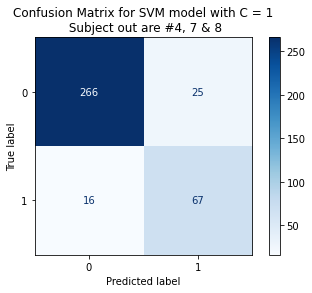

In [19]:
clf4 = pickle.load(open('Models/SVM_linear_3_subjects_out.sav', 'rb'))
y_predicted_subject_out = clf4.predict(X_subject_out)
print('Accuracy with another subject:', accuracy_score(y_subject_out, y_predicted_subject_out))

con_mat = confusion_matrix(y_true=y_subject_out, y_pred=y_predicted_subject_out)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with C = 1\n Subject out are #4, 7 & 8')
plt.show()

#### Saving model to disk

In [32]:
pickle.dump(clf4, open('SVM_linear_3_subjects_out.sav', 'wb'))

## Creating model with FallAllD compatibility with DOFDA dataset

Generating 4 random numbers so this way those subjects from DOFDA dataset are going to be used to test the models.

#### Generating random numbers

This random numbers will determine which subjects from DOFDA dataset will be used for testing the model trained with FallAllD dataset.

In [56]:
dofda_subjects = []
seed(628472)
for x in range(4):
   dofda_subjects.append(randint(1,24))

dofda_subjects

[18, 6, 4, 24]

#### Creating a new dataframe of FallAllD

Since the sampling frequency and sensor sensitivity is different, we have to adapt FallAllD so it can be compared to DOFDA dataset.

In [68]:
original_df = pd.read_pickle('FallAllD.pkl')     # Reading original Dataset

FallAllD_compatible = original_df.copy()         # Creating a copy of original datset into the variable
FallAllD_compatible['Fall'] = 0                  # Creating a new column with Fall, which become our output
for x in FallAllD_compatible.index:
    if (FallAllD_compatible.iloc[x, 2] > 100):           # Checking whether the row represents a Fall or ADL, second index refers to ActivityID
        FallAllD_compatible.iloc[x, -1] = 1              # If activity ID is above 100, the row represents a Fall
    else:
        FallAllD_compatible.iloc[x, -1] = 0              # Else, row represents a ADL

FallAllD_compatible['Acc'] = FallAllD_compatible['Acc'] * 0.004        # Since values are not stored with original values, this becomes useful
FallAllD_compatible['Gyr'] = FallAllD_compatible['Gyr'] * (1/14.375)   # to modify data to become the same as another sensor used by another project
FallAllD_compatible['Mag'] = FallAllD_compatible['Mag'] * 0.004        # so to get real data we will multiply each value by the respective sensor sensitivy

FallAllD_compatible.tail()

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Fall
1793,15,Waist,131,2,"[[15.22, 3.3080000000000003, 1.856], [15.288, ...","[[8.695652173913043, -10.921739130434784, -32....","[[11.452, 2.468, 16.728], [11.564, 2.74, 16.80...",1
1794,15,Waist,132,1,"[[16.076, -2.168, 2.2560000000000002], [16.056...","[[-1.3217391304347825, 1.2521739130434784, 0.8...","[[14.268, 2.348, 6.828], [14.244, 1.972, 6.736...",1
1795,15,Waist,134,2,"[[15.536, -6.0, 2.228], [15.5, -5.94, 2.280000...","[[2.9217391304347826, 2.9217391304347826, -0.5...","[[10.508000000000001, 9.852, -1.768], [10.9, 9...",1
1796,15,Waist,135,1,"[[16.18, -0.608, 1.62], [16.172, -0.5720000000...","[[1.4608695652173913, 0.48695652173913045, 0.0...","[[14.084, 3.436, 13.016], [14.236, 3.428, 13.0...",1
1797,15,Waist,135,2,"[[16.024, -2.7640000000000002, 0.0720000000000...","[[-0.1391304347826087, 0.6260869565217392, 0.4...","[[13.276, 9.78, 5.136], [13.396, 9.62000000000...",1


#### Adding Statistical features

In [70]:
# Since we are going to be using basic statistical features, we need to create new columns for each one of them
# Those features are: Mean, Standar Deviation and Range.
# We create a new column for each feature and for each axis, then we have 9 new columns for each sensor
# Totalling 9 new columns per sensor, finally creating 18 new columns
FallAllD_compatible['Mean Acc X'] = -1
FallAllD_compatible['Mean Acc Y'] = -1
FallAllD_compatible['Mean Acc Z'] = -1
FallAllD_compatible['Std Acc X'] = -1
FallAllD_compatible['Std Acc Y'] = -1
FallAllD_compatible['Std Acc Z'] = -1
FallAllD_compatible['Rng Acc X'] = -1
FallAllD_compatible['Rng Acc Y'] = -1
FallAllD_compatible['Rng Acc Z'] = -1

FallAllD_compatible['Mean Gyr X'] = -1
FallAllD_compatible['Mean Gyr Y'] = -1
FallAllD_compatible['Mean Gyr Z'] = -1
FallAllD_compatible['Std Gyr X'] = -1
FallAllD_compatible['Std Gyr Y'] = -1
FallAllD_compatible['Std Gyr Z'] = -1
FallAllD_compatible['Rng Gyr X'] = -1
FallAllD_compatible['Rng Gyr Y'] = -1
FallAllD_compatible['Rng Gyr Z'] = -1

FallAllD_compatible['Mean Mag X'] = -1
FallAllD_compatible['Mean Mag Y'] = -1
FallAllD_compatible['Mean Mag Z'] = -1
FallAllD_compatible['Std Mag X'] = -1
FallAllD_compatible['Std Mag Y'] = -1
FallAllD_compatible['Std Mag Z'] = -1
FallAllD_compatible['Rng Mag X'] = -1
FallAllD_compatible['Rng Mag Y'] = -1
FallAllD_compatible['Rng Mag Z'] = -1
''''''
for x in FallAllD_compatible.index:
    
    AccX = pd.DataFrame(FallAllD_compatible.iloc[x].Acc.tolist())[0]     # Creating a dataframe containing acceleration in X
    AccY = pd.DataFrame(FallAllD_compatible.iloc[x].Acc.tolist())[1]     # Creating a dataframe containing acceleration in Y
    AccZ = pd.DataFrame(FallAllD_compatible.iloc[x].Acc.tolist())[2]     # Creating a dataframe containing acceleration in Z
    
    GyrX = pd.DataFrame(FallAllD_compatible.iloc[x].Gyr.tolist())[0]     # Creating a dataframe containing angular velocity in X
    GyrY = pd.DataFrame(FallAllD_compatible.iloc[x].Gyr.tolist())[1]     # Creating a dataframe containing angular velocity in Y
    GyrZ = pd.DataFrame(FallAllD_compatible.iloc[x].Gyr.tolist())[2]     # Creating a dataframe containing angular velocity in Z

    MagX = pd.DataFrame(FallAllD_compatible.iloc[x].Mag.tolist())[0]     # Creating a dataframe containing magnetic field in X
    MagY = pd.DataFrame(FallAllD_compatible.iloc[x].Mag.tolist())[1]     # Creating a dataframe containing magnetic field in Y
    MagZ = pd.DataFrame(FallAllD_compatible.iloc[x].Mag.tolist())[2]     # Creating a dataframe containing magnetic field in Z

    FallAllD_compatible.iloc[x, 8] = AccX.mean()                         # Setting the value of Mean acceleration in X, Y and Z
    FallAllD_compatible.iloc[x, 9] = AccY.mean()                         
    FallAllD_compatible.iloc[x, 10] = AccZ.mean()                        
    FallAllD_compatible.iloc[x, 11] = AccX.std()                         # Setting the value of the Standard Deviation of acceleration in X, Y and Z
    FallAllD_compatible.iloc[x, 12] = AccY.std()
    FallAllD_compatible.iloc[x, 13] = AccZ.std()
    FallAllD_compatible.iloc[x, 14] = AccX.max() - AccX.min()            # Setting the value of the Range of acceleration in X, Y and Z
    FallAllD_compatible.iloc[x, 15] = AccY.max() - AccY.min()
    FallAllD_compatible.iloc[x, 16] = AccZ.max() - AccZ.min()

    FallAllD_compatible.iloc[x, 17] = GyrX.mean()                        # Setting the value of Mean angular velocity in X, Y and Z
    FallAllD_compatible.iloc[x, 18] = GyrY.mean()
    FallAllD_compatible.iloc[x, 19] = GyrZ.mean()
    FallAllD_compatible.iloc[x, 20] = GyrX.std()                         # Setting the value of the Standard Deviation of angular velocity in X, Y and Z
    FallAllD_compatible.iloc[x, 21] = GyrY.std()
    FallAllD_compatible.iloc[x, 22] = GyrZ.std()
    FallAllD_compatible.iloc[x, 23] = GyrX.max() - GyrX.min()            # Setting the value of the Range of angular velocity in X, Y and Z
    FallAllD_compatible.iloc[x, 24] = GyrY.max() - GyrY.min()
    FallAllD_compatible.iloc[x, 25] = GyrZ.max() - GyrZ.min()

    FallAllD_compatible.iloc[x, 26] = MagX.mean()                        # Setting the value of Mean magnetic field in X, Y and Z
    FallAllD_compatible.iloc[x, 27] = MagY.mean()
    FallAllD_compatible.iloc[x, 28] = MagZ.mean()
    FallAllD_compatible.iloc[x, 29] = MagX.std()                         # Setting the value of the Standard Deviation of magnetic field in X, Y and Z
    FallAllD_compatible.iloc[x, 30] = MagY.std()
    FallAllD_compatible.iloc[x, 31] = MagZ.std()
    FallAllD_compatible.iloc[x, 32] = MagX.max() - MagX.min()            # Setting the value of the Range of magnetic field in X, Y and Z
    FallAllD_compatible.iloc[x, 33] = MagY.max() - MagY.min()
    FallAllD_compatible.iloc[x, 34] = MagZ.max() - MagZ.min()

col = FallAllD_compatible.pop('Fall')            # Popping Fall column

FallAllD_compatible.insert(34, col.name, col)    # Rearranging columns, so Fall column will be at the end of the dataframe

FallAllD_compatible.head()
#FallAllD_compatible.to_pickle('FallAllD with DOFDA sampling frequency and sensitivity.pkl')

,SubjectID,Device,ActivityID,TrialNo,Acc,Gyr,Mag,Mean Acc X,Mean Acc Y,Mean Acc Z,...,Mean Mag X,Mean Mag Y,Mean Mag Z,Std Mag X,Std Mag Y,Std Mag Z,Rng Mag X,Rng Mag Y,Rng Mag Z,Fall
0,1,Waist,13,1,"[[16.248, -5.712, -0.18], [16.76, -5.688, -0.0...","[[94.26086956521739, 1.4608695652173913, 11.06...","[[22.164, 6.204, 11.548], [22.272000000000002,...",15.107906,-3.304263,2.816519,...,22.528833,8.753138,7.112868,0.867299,1.791368,2.955682,4.560,7.796,10.300,0
1,1,Waist,13,2,"[[14.948, -6.196, 0.632], [14.916, -6.212, 0.6...","[[-0.2782608695652174, 0.0, -0.069565217391304...","[[20.740000000000002, 11.368, 9.068], [20.88, ...",14.912928,-4.493977,2.865341,...,21.605538,10.855000,7.301168,0.941924,0.973376,2.136848,4.188,4.676,6.412,0
2,1,Waist,13,5,"[[15.816, -1.604, -0.428], [15.576, -1.3840000...","[[12.31304347826087, 12.034782608695652, 12.31...","[[22.504, 8.592, 12.228], [22.408, 8.508000000...",15.149850,-0.146541,3.483840,...,22.847735,7.259533,7.725542,0.481693,1.477191,3.302708,2.832,7.520,11.996,0
3,1,Waist,13,6,"[[15.968, -2.728, -0.132], [15.952, -2.7760000...","[[0.8347826086956522, 0.9043478260869565, 0.62...","[[22.12, 10.144, 10.852], [22.084, 10.244, 11....",14.913143,-0.523803,3.846560,...,22.217548,9.101418,8.015515,0.448306,1.068934,3.414722,2.704,4.972,9.148,0
4,1,Waist,13,9,"[[8.892, 0.668, -0.07200000000000001], [8.5560...","[[-27.547826086956523, -11.339130434782609, 2....","[[23.008, 8.284, 10.892], [23.204, 8.88, 10.46...",14.817563,2.799566,3.498118,...,23.091453,5.798868,7.557822,0.601801,1.480950,3.262800,2.848,8.196,11.228,0


#### Separating values for independent and dependent variables

In [74]:
X_fallalld_compatible = FallAllD_compatible.iloc[:, 7:34]
y_fallalld_compatible = FallAllD_compatible['Fall']

1793    1
1794    1
1795    1
1796    1
1797    1
Name: Fall, dtype: int64

#### Train and test split of variables

In [82]:
X_fallalld_compatible_rem, X_test_fallalld, y_fallalld_compatible_rem, y_test_fallalld = train_test_split(X_fallalld_compatible, y_fallalld_compatible, 
                                                                                                  test_size=0.1, train_size=0.9, random_state=1087,
                                                                                                  stratify=y_fallalld_compatible)
X_fallalld_compatible.shape, X_test_fallalld.shape

((1456, 27), (146, 27))

#### Training and validating model

In [85]:
scores_fallalld_dofda = []
clf_fallalld_dofda= SVC(kernel='linear')

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=959)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X_fallalld_compatible_rem, y_fallalld_compatible_rem):                      # Splitting dataset into 10 fold 
    X_train, X_val = X_fallalld_compatible_rem.iloc[train_index], X_fallalld_compatible_rem.iloc[val_index]
    y_train, y_val = y_fallalld_compatible_rem.iloc[train_index] , y_fallalld_compatible_rem.iloc[val_index]

    clf_fallalld_dofda.fit(X_train, y_train)
    scores_fallalld_dofda.append(clf_fallalld_dofda.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_fallalld_dofda) / len(scores_fallalld_dofda))

{"ok":true,"result":{"message_id":102,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634418684,"text":"Training is done!"}}
Linear accuracy score:  0.9450381679389313


#### Testing model with testing set

In [86]:
y2_predicted_fallalld_compatible = clf_fallalld_dofda.predict(X_test_fallalld)
print('Accuracy: ', (accuracy_score(y_test_fallalld, y2_predicted_fallalld_compatible))*100)

Accuracy:  93.83561643835617


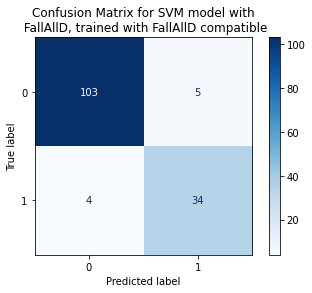

In [91]:
con_mat = confusion_matrix(y_true=y_test_fallalld, y_pred=y2_predicted_fallalld_compatible)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n FallAllD, trained with FallAllD compatible')
plt.show()

#### Testing model with DOFDA dataset subjects 

##### Reading DOFDA sub-dataset

In [3]:
DOFDA_df = pd.read_csv(open('Dataframes/DOFDA 4 subjects for testing.csv', 'rb'), delimiter=',')
DOFDA_df.tail()

,Mean Acc X,Mean Acc Y,Mean Acc Z,Std Acc X,Std Acc Y,Std Acc Z,Rng Acc X,Rng Acc Y,Rng Acc Z,Mean Gyr X,...,Mean Mag X,Mean Mag Y,Mean Mag Z,Std Mag X,Std Mag Y,Std Mag Z,Rng Mag X,Rng Mag Y,Rng Mag Z,Fall
67,0.070096,0.563910,0.535160,0.338486,0.457539,0.540654,3.48,6.31,4.47,-2.756058,...,300.734038,-571.446346,-216.737179,103.578420,89.140299,163.126135,331.23,389.80,669.0,1
68,-0.016308,0.297744,0.809179,0.279730,0.283066,0.254771,2.40,4.33,2.62,-0.412051,...,101.418718,-136.274718,-337.753846,34.871670,91.486274,45.546830,201.83,252.09,142.0,1
69,0.304257,0.102635,0.778108,0.405994,0.128554,0.444629,1.71,1.08,5.16,0.903108,...,59.730270,-203.792027,-400.655405,9.749718,117.407574,42.991469,69.76,294.17,112.0,1
70,0.255825,0.429417,0.682379,0.402068,0.210516,0.172435,2.24,1.56,1.48,2.746359,...,198.538786,-215.794806,-345.815534,44.917560,143.032130,49.186834,141.88,348.89,214.0,1
71,0.597984,0.040801,0.633514,0.430405,0.134818,0.164730,5.94,2.20,2.43,-0.810413,...,125.012016,-415.746021,-442.723514,16.473693,150.056965,39.399675,113.25,483.23,174.0,1


##### Separating variables

In this mini section we will be separating variables from those subjects chosen randomly from DOFDA dataset

In [4]:
X_DOFDA = DOFDA_df.iloc[:, 0:-1]
y_DOFDA = DOFDA_df['Fall']

##### Predicting ouput

In [98]:
y_predicted_DOFDA = clf_fallalld_dofda.predict(X_DOFDA)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted_DOFDA))*100)

Accuracy:  76.38888888888889


##### Plotting Confusion Matrix for DOFDA test

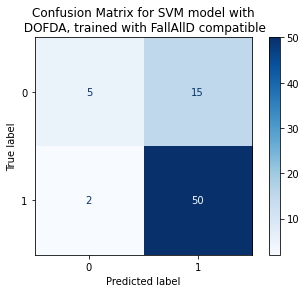

In [99]:
con_mat = confusion_matrix(y_true=y_DOFDA, y_pred=y_predicted_DOFDA)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n DOFDA, trained with FallAllD compatible')
plt.show()

##### Saving model to disk

In [100]:
pickle.dump(clf_fallalld_dofda, open('SVM_linear_FallAllD_DOFDA.sav', 'wb'))

## Testing every model with DOFDA subset

Accuracy:  73.61111111111111


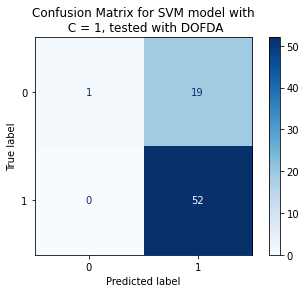

In [23]:
classifier = pickle.load(open('Models/SVM_linear_1.sav', 'rb'))

y_predicted = classifier.predict(X_DOFDA)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted))*100)

con_mat = confusion_matrix(y_true=y_DOFDA, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n C = 1, tested with DOFDA')
plt.show()

Accuracy:  73.61111111111111


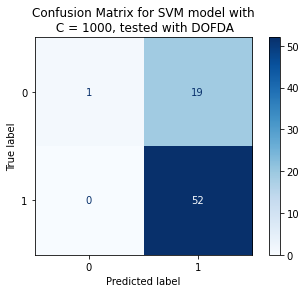

In [25]:
classifier = pickle.load(open('Models/SVM_linear_1000.sav', 'rb'))

y_predicted = classifier.predict(X_DOFDA)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted))*100)

con_mat = confusion_matrix(y_true=y_DOFDA, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n C = 1000, tested with DOFDA')
plt.show()

Accuracy:  88.88888888888889


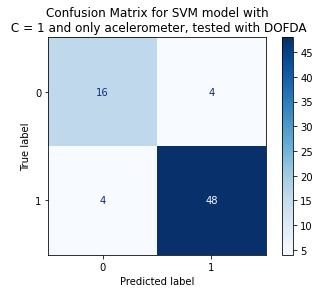

In [27]:
classifier = pickle.load(open('Models/SVM_linear_1_dataframe5.sav', 'rb'))

X_DOFDA_2 = X_DOFDA.iloc[:, 0:9]
y_predicted = classifier.predict(X_DOFDA_2)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted))*100)

con_mat = confusion_matrix(y_true=y_DOFDA, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n C = 1 and only acelerometer, tested with DOFDA')
plt.show()

Accuracy:  86.11111111111111


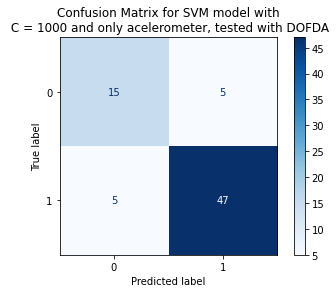

In [29]:
classifier = pickle.load(open('Models/SVM_linear_1000_dataframe5.sav', 'rb'))
y_predicted = classifier.predict(X_DOFDA_2)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted))*100)

con_mat = confusion_matrix(y_true=y_DOFDA, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n C = 1000 and only acelerometer, tested with DOFDA')
plt.show()

In [132]:
classifier = pickle.load(open('SVM_linear_subject_out.sav', 'rb'))
y_predicted = classifier.predict(X_DOFDA)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted))*100)

Accuracy:  73.61111111111111


Accuracy:  68.05555555555556


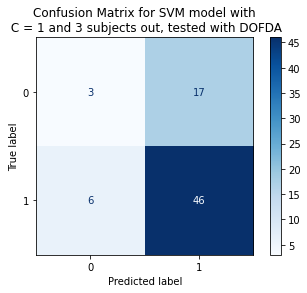

In [6]:
classifier = pickle.load(open('Models/SVM_linear_3_subjects_out.sav', 'rb'))
y_predicted = classifier.predict(X_DOFDA)
print('Accuracy: ', (accuracy_score(y_DOFDA, y_predicted))*100)

con_mat = confusion_matrix(y_true=y_DOFDA, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM model with\n C = 1 and 3 subjects out, tested with DOFDA')
plt.show()